In [3]:
!pip install mtcnn tqdm lz4 joblib

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from mtcnn import MTCNN
from tqdm import tqdm
import shutil

In [5]:
np.random.seed(42)
lfw_people = fetch_lfw_people(min_faces_per_person=5, resize=1.0, color=True)

images = lfw_people.images
targets = lfw_people.target
target_names = lfw_people.target_names

print(f"Dataset contains {len(images)} images of {len(target_names)} unique people.")


Dataset contains 5985 images of 423 unique people.


In [6]:
raw_image_path = "data/raw_images"
os.makedirs(raw_image_path, exist_ok=True)

for i, img in enumerate(images):
    img_pil = Image.fromarray((img * 255).astype(np.uint8))
    img_pil.save(f"{raw_image_path}/img_{i:04d}.jpg")



[INFO] Analyzing image distribution...


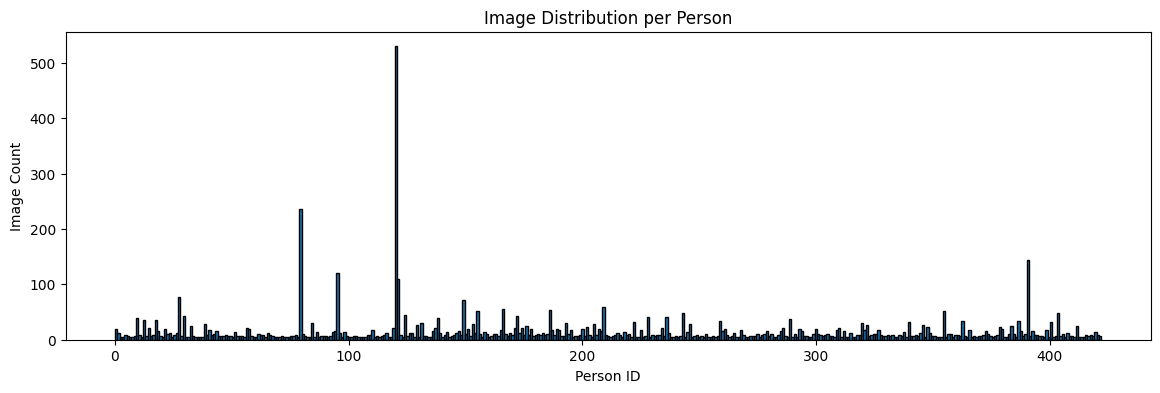

In [7]:
print("\n[INFO] Analyzing image distribution...")
count_per_person = Counter(targets)

plt.figure(figsize=(14, 4))
plt.hist(targets, bins=len(target_names), edgecolor='k')
plt.title("Image Distribution per Person")
plt.xlabel("Person ID")
plt.ylabel("Image Count")
plt.show()


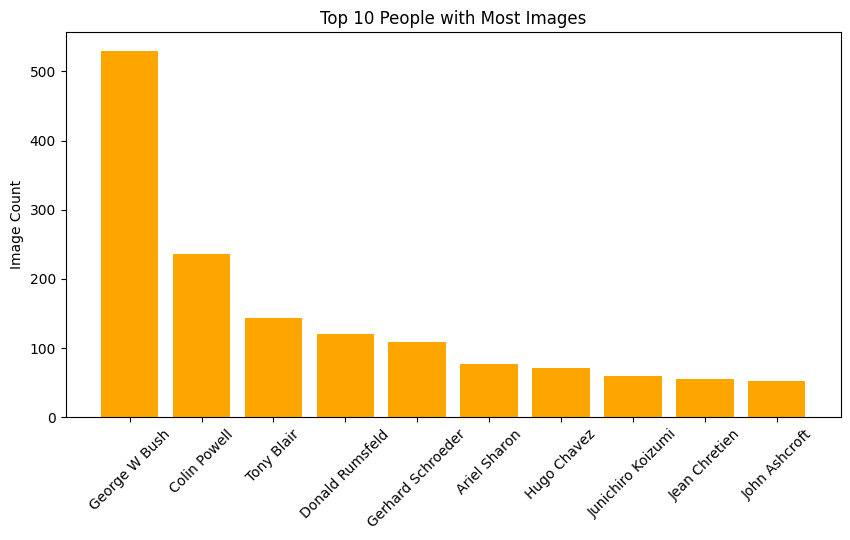

In [8]:
top_10_persons = count_per_person.most_common(10)
names = [target_names[i] for i, _ in top_10_persons]
counts = [c for _, c in top_10_persons]

plt.figure(figsize=(10, 5))
plt.bar(names, counts, color="orange")
plt.xticks(rotation=45)
plt.title("Top 10 People with Most Images")
plt.ylabel("Image Count")
plt.show()


In [9]:
detector = MTCNN()

processed_images = []
processed_labels = []

for i, img in tqdm(enumerate(images), total=len(images)):
    img_rgb = (img * 255).astype(np.uint8)
    face = detector.detect_faces(img_rgb)

    if face:
        x, y, w, h = face[0]['box']
        x, y = max(0, x), max(0, y)
        cropped_face = img_rgb[y:y+h, x:x+w]
        resized_face = np.array(Image.fromarray(cropped_face).resize((160, 160)))
        normalized_face = (resized_face / 127.5) - 1.0
        processed_images.append(normalized_face)
        processed_labels.append(targets[i])


100%|██████████| 5985/5985 [11:08<00:00,  8.95it/s]


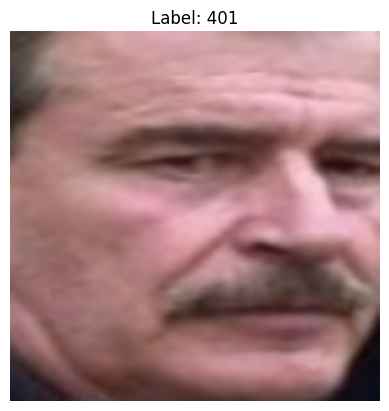

In [10]:
if processed_images:
    plt.imshow((processed_images[0] + 1) / 2)
    plt.title(f"Label: {processed_labels[0]}")
    plt.axis('off')
    plt.show()
else:
    print("No processed faces to display.")


In [16]:
import gc

processed_labels_np = np.array(processed_labels)


try:
    processed_images_np = np.array(processed_images, dtype='float32')
except MemoryError:
    print("MemoryError: Splitting image array conversion in smaller chunks...")
    chunk_size = 1000
    processed_images_np = []
    for i in range(0, len(processed_images), chunk_size):
        chunk = np.array(processed_images[i:i+chunk_size], dtype='float32')
        processed_images_np.append(chunk)
    processed_images_np = np.concatenate(processed_images_np, axis=0)
    gc.collect()

X_train, X_test, y_train, y_test = train_test_split(
    processed_images_np, processed_labels_np,
    test_size=0.2, stratify=processed_labels_np, random_state=42)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")



Training set: (4708, 160, 160, 3), Testing set: (1177, 160, 160, 3)


In [15]:
os.makedirs("data/processed", exist_ok=True)
np.save("data/processed/X_train.npy", X_train)
np.save("data/processed/y_train.npy", y_train)
np.save("data/processed/X_test.npy", X_test)
np.save("data/processed/y_test.npy", y_test)
print("Data saved to 'data/processed/'")


Data saved to 'data/processed/'
